# Exploratory Data Analysis (EDA)

Importing the libraries and functions

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, kstest, norm
import seaborn as sns

# Functions developed for the project
from src.statistics import (
    levene_analysis,
    mannwhitneyu_analysis,
    ttest_ind_analysis,
    remove_outliers,
)
from src.config import PROCESSED_DATA

### Loading the Processed Data and Doing a Quick Overview
To begin the statistical analysis, we load the previously saved Parquet file into a new DataFrame:

This quick overview helps confirm that the data is intact and ready for analysis.

In [2]:
df_diabetes_processed = pd.read_parquet(PROCESSED_DATA)

df_diabetes_processed.head()

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GeneralHealth,DaysMentalHealth,DaysPhysicalHealth,DiffWalk,Sex,Age,Education,Income
0,No,Yes,No,Yes,26,No,No,No,Yes,No,...,Yes,No,Good,5,30,No,Male,35-39,Undergrad. +,$75.000+
1,No,Yes,Yes,Yes,26,Yes,Yes,No,No,Yes,...,Yes,No,Good,0,0,No,Male,75-79,Undergrad. +,$75.000+
2,No,No,No,Yes,26,No,No,No,Yes,Yes,...,Yes,No,Excellent,0,10,No,Male,80+,Undergrad. +,$75.000+
3,No,Yes,Yes,Yes,28,Yes,No,No,Yes,Yes,...,Yes,No,Good,0,3,No,Male,70-74,Undergrad. +,$75.000+
4,No,No,No,Yes,29,Yes,No,No,Yes,Yes,...,Yes,No,Very good,0,0,No,Female,55-59,Inc. undergrad. or technical course,$75.000+


In [3]:
df_diabetes_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Diabetes              70692 non-null  category
 1   HighBP                70692 non-null  category
 2   HighChol              70692 non-null  category
 3   CholCheck             70692 non-null  category
 4   BMI                   70692 non-null  int8    
 5   Smoker                70692 non-null  category
 6   Stroke                70692 non-null  category
 7   HeartDiseaseorAttack  70692 non-null  category
 8   PhysActivity          70692 non-null  category
 9   Fruits                70692 non-null  category
 10  Veggies               70692 non-null  category
 11  HvyAlcoholConsump     70692 non-null  category
 12  AnyHealthcare         70692 non-null  category
 13  NoDocbcCost           70692 non-null  category
 14  GeneralHealth         70692 non-null  category
 15  Da

### Categorizing the Data Columns for Analysis
Before performing statistical analysis, we classify the columns in the dataset into different categories: numerical, categorical, binary, and non-binary.

#### **Steps Taken:**
1. **Identify Numerical Columns**: Using `select_dtypes(include="number")`, we gather all numerical columns for further analysis.
2. **Define Target Column**: The `"Diabetes"` column is specified as the target variable for predictive modeling or statistical analysis.
3. **Categorical Columns**: We identify all categorical columns, excluding the target column (`"Diabetes"`), as they represent non-numerical attributes that might have useful relationships with the target.
4. **Binary Columns**: Binary columns are those that contain only two unique values. These are identified using `nunique()`, and the `"Diabetes"` column is removed from the list of binary columns.
5. **Non-Binary Columns**: The remaining categorical columns that have more than two unique categories are considered non-binary. We compute this by taking the difference between the categorical and binary columns.

This classification will help organize the analysis and guide us in selecting appropriate statistical techniques for each column type.

In [4]:
numerical_columns = df_diabetes_processed.select_dtypes(include="number").columns.tolist()

target_column = "Diabetes"

categorical_columns = df_diabetes_processed.select_dtypes(include="category").columns.tolist()
categorical_columns.remove(target_column)

binary_columns = df_diabetes_processed.nunique()[df_diabetes_processed.nunique() == 2].index.tolist()
binary_columns.remove(target_column)

non_binary_columns = list(set(categorical_columns) - set(binary_columns))

### Visualizing Distributions of Numerical Variables by Target Category
We create a **boxplot** for each numerical variable, grouped by the target column (`"Diabetes"`) to visually inspect the distribution of numerical features across the target classes. Boxplots provide insights into:

- **Central tendency** (median).
- **Spread** (interquartile range, IQR).
- **Presence of outliers** (data points outside the whiskers).

This visualization will help us understand if there are any significant differences in the distributions of the numerical features for the different categories of the target variable.


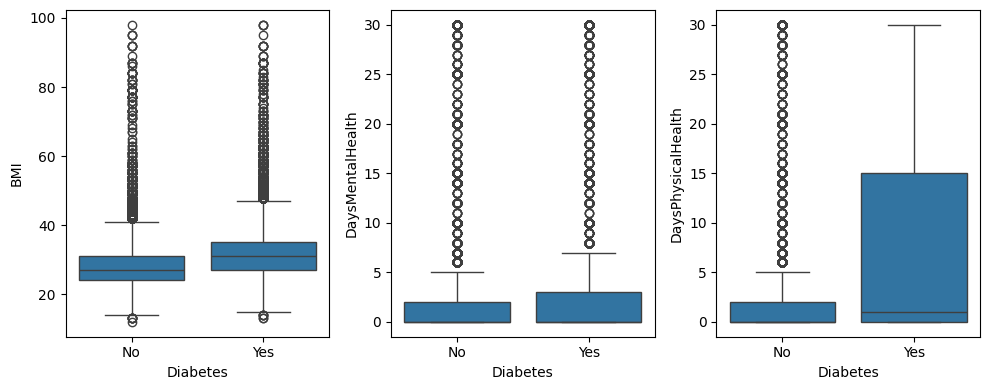

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, column in zip(axs, numerical_columns):
    sns.boxplot(data=df_diabetes_processed, x=target_column, y=column, ax=ax)

plt.tight_layout()
plt.show()


We use **histograms with Kernel Density Estimation (KDE)** to visualize the distribution of each numerical variable, stratified by the target column. The KDE helps us understand the **smooth distribution** of the data, providing a clearer view of its shape.

This allows us to visually inspect the distributions of numerical variables for both categories of the target variable and identify any potential patterns or discrepancies.

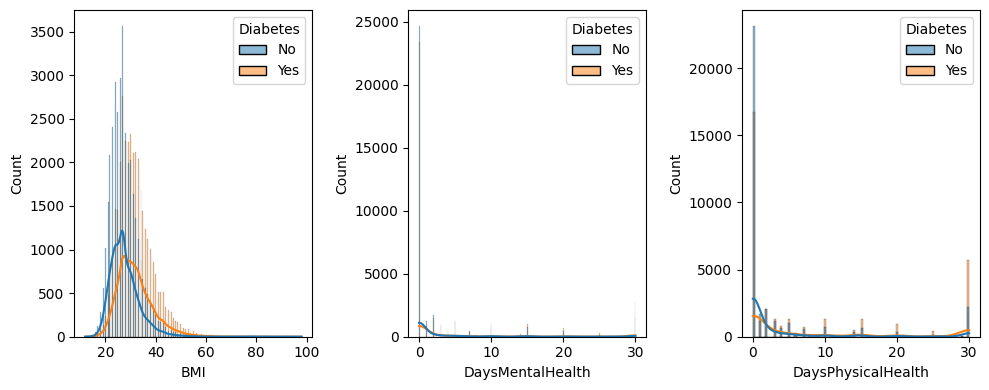

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for ax, column in zip(axs, numerical_columns):
    sns.histplot(data=df_diabetes_processed, x=column, hue=target_column, kde=True, ax=ax)

plt.tight_layout()
plt.show()

### Analyzing Differences in BMI Between Diabetics and Non-Diabetics
To investigate whether there is a significant difference in **BMI** between diabetics and non-diabetics, we group the dataset by the target column and use `.describe()` to generate descriptive statistics for each group.

In [7]:
df_diabetes_processed.groupby(target_column, observed=False).describe().T

Diabetes                            No           Yes
BMI                count  35346.000000  35346.000000
                   mean      27.769960     31.944011
                   std        6.187636      7.363401
                   min       12.000000     13.000000
                   25%       24.000000     27.000000
                   50%       27.000000     31.000000
                   75%       31.000000     35.000000
                   max       98.000000     98.000000
DaysMentalHealth   count  35346.000000  35346.000000
                   mean       3.042268      4.461806
                   std        7.208408      8.947717
                   min        0.000000      0.000000
                   25%        0.000000      0.000000
                   50%        0.000000      0.000000
                   75%        2.000000      3.000000
                   max       30.000000     30.000000
DaysPhysicalHealth count  35346.000000  35346.000000
                   mean       3.666355      7.954479
                   std        8.098339     11.301491
                   min        0.000000      0.000000
                   25%        0.000000      0.000000
                   50%        0.000000      1.000000
                   75%        2.000000     15.000000
                   max       30.000000     30.000000

### Insights on the Relationship Between Diabetes and BMI

From the summary statistics provided, we can draw some insights about how BMI (Body Mass Index) relates to diabetes:

1. **Mean BMI Difference**:
   - **Non-diabetics** have a mean BMI of **27.77**.
   - **Diabetics** have a higher mean BMI of **31.94**.
   - The difference in the mean BMI between diabetics and non-diabetics is approximately **4.17 units**, suggesting that diabetics, on average, tend to have a higher BMI compared to non-diabetics.

2. **BMI Distribution**:
   - The **standard deviation** for BMI in diabetics (**7.36**) is higher than in non-diabetics (**6.19**), which indicates more variability in BMI within the diabetic group.
   - The **25th percentile (25%)** for diabetics is **27**, and for non-diabetics, it is **24**, further suggesting that a larger proportion of diabetics have a higher BMI, especially in the lower quartile.
   - The **75th percentile (75%)** for diabetics is **35**, compared to **31** for non-diabetics, reinforcing the trend of higher BMI among diabetics.

3. **Outliers**:
   - The **maximum BMI** for both groups is the same (**98**), indicating that extremely high BMI values are present in both diabetics and non-diabetics. However, these outliers may not significantly affect the overall trends seen in the summary statistics, but they should be explored further in detail if needed.

4. **BMI and Risk**:
   - Given that higher BMI is often associated with an increased risk of conditions like Type 2 diabetes, the higher mean BMI for diabetics is consistent with medical literature. This suggests a possible association between higher BMI and the presence of diabetes in this dataset.

#### **Conclusion**:
From the descriptive statistics, it appears that individuals with diabetes tend to have a higher BMI on average compared to those without diabetes. This reinforces the idea that obesity or higher BMI is a significant factor associated with the development of diabetes. Further analysis, such as correlation or statistical tests, would provide more insights into the strength and significance of this relationship.


- Student's t-test to compare BMI means between diabetics and non-diabetics?
- Or Mann-Whitney U test to compare BMI medians between diabetics and non-diabetics?

### Checking the skewness of numerical variables grouped by diabetes status

Skewness measures asymmetry in the distribution:
- A skewness close to 0 suggests a symmetric (normal-like) distribution.
- Positive skewness means a right-skewed distribution (long tail on the right).
- Negative skewness means a left-skewed distribution (long tail on the left).

In [8]:
df_diabetes_processed.groupby(target_column, observed=False).skew(numeric_only=True)

,BMI,DaysMentalHealth,DaysPhysicalHealth
Diabetes,,,
No,2.231015,2.808070,2.480202
Yes,1.527018,2.065169,1.150047


### Checking the kurtosis of numerical variables grouped by diabetes status

Kurtosis measures the "tailedness" of a distribution:
- A kurtosis of 3 suggests a normal distribution.
- Higher values (>3) indicate heavy tails (more extreme values).
- Lower values (<3) indicate light tails (fewer extreme values).

In [9]:
df_diabetes_processed.groupby(target_column, observed=False)[numerical_columns].apply(pd.DataFrame.kurtosis)

,BMI,DaysMentalHealth,DaysPhysicalHealth
Diabetes,,,
No,12.901012,7.012218,4.910598
Yes,5.717382,2.873176,-0.341922


In [10]:
# Extracting BMI values for diabetics and non-diabetics

data_bmi_yes = df_diabetes_processed.query("Diabetes == 'Yes'")["BMI"].values

data_bmi_no = df_diabetes_processed.query("Diabetes == 'No'")["BMI"].values

### Performing the Kolmogorov-Smirnov (KS) test for normality

The KS test compares the sample distribution to a normal distribution with the same mean and standard deviation.
 
- H0 (null hypothesis): Data follows a normal distribution.
- If p-value < 0.05, we reject H0, meaning the data is not normally distributed.
- If p-value > 0.05, we fail to reject H0, meaning the data could be normally distributed.

In [11]:
print(kstest(data_bmi_no, norm.cdf, args=(data_bmi_no.mean(), data_bmi_no.std())))
print(kstest(data_bmi_yes, norm.cdf, args=(data_bmi_yes.mean(), data_bmi_yes.std())))

KstestResult(statistic=0.1209153634702329, pvalue=0.0, statistic_location=28, statistic_sign=1)
KstestResult(statistic=0.10452803408478695, pvalue=0.0, statistic_location=33, statistic_sign=1)


#### **Interpretation:**  
1. The **p-values are 0.0**, meaning we **reject the null hypothesis** (H₀).  
   - This indicates that **BMI does not follow a normal distribution** for either group.  
2. The **KS statistic** quantifies the maximum difference between the empirical and normal distributions.  
   - Both groups have KS statistics around **0.1**, meaning they **deviate significantly from normality**.  
3. The **statistic_location values (28 for non-diabetics, 33 for diabetics)** indicate where the largest deviation from normality occurs.  
   - This suggests that BMI values around **28 (non-diabetics) and 33 (diabetics)** are where the distribution differs the most from normal.  

#### **Key Takeaways:**  
- **BMI is not normally distributed** for either diabetics or non-diabetics.  
- Given the **skewed nature** of BMI, **non-parametric tests** (e.g., Mann-Whitney U test) might be better for comparing groups.   

### **Statistical Tests for BMI Differences between Diabetics and Non-Diabetics** 

Creating a new dataframe to facilitate the analysis

In [12]:
df_bmi = pd.DataFrame({"Yes": data_bmi_yes, "No": data_bmi_no})

df_bmi

,Yes,No
0,30,26
1,25,26
2,28,26
3,23,28
4,27,29
...,...,...
35341,37,23
35342,29,29
35343,25,24
35344,18,53


1. **Levene’s Test** (for equality of variances)  
   - Tests whether the variance of BMI is equal between the two groups.  
   - Null Hypothesis (H₀): The variances are equal.  
   - If p-value < 0.05 → Reject H₀, meaning the variances are significantly different.

In [13]:
levene_analysis(df_bmi, center="median")

Levene's Test
statistics_levene=888.297
At least one variance is different (p-value: 0.000)


- Because the variances are unequal, the **Student’s t-test should use Welch’s correction** (which accounts for unequal variances).  
- Alternatively, we can rely more on the **Mann-Whitney U test**, which is a non-parametric alternative that does not assume equal variances.

2. **Student’s t-test** (for mean differences)  
   - Compares the average BMI between diabetics and non-diabetics.  
   - Assumes normality and equal variances (or uses Welch’s correction if variances are unequal).  
   - Null Hypothesis (H₀): The means are equal.  
   - If p-value < 0.05 → Reject H₀, meaning there is a significant difference in means. 

In [14]:
ttest_ind_analysis(df_bmi, equal_variances=False) # Note the usage of the Welch's correction to account for unequal variance

Student's t-test
statistics_ttest=81.591
Rejects the null hypothesis (p-value: 0.000)


This means that **there is a statistically significant difference in BMI** between diabetics and non-diabetics.  


3. **Mann-Whitney U Test** (non-parametric test)  
   - Compares the distributions of BMI between the two groups.  
   - Useful because BMI is not normally distributed.  
   - Null Hypothesis (H₀): The distributions are the same.  
   - If p-value < 0.05 → Reject H₀, meaning the distributions are significantly different.

In [15]:
mannwhitneyu_analysis(df_bmi)

Mann-Whitney's Test
statistics_mw=861173484.000
Rejects the null hypothesis (p-value: 0.000)


- This confirms that the BMI distribution **differs significantly** between diabetics and non-diabetics. 
- Since we **already found significant differences in mean BMI** (via the t-test), this result **reinforces** the conclusion that diabetics tend to have **higher BMI values**.

### **Final Conclusion:**  
Across all three tests (**Levene’s, Student's t, and Mann-Whitney's**), we consistently find that diabetics have **higher and differently distributed BMI values** compared to non-diabetics. These findings are **statistically significant** and highlight an important link between **higher BMI and diabetes**.  

**Do the Outliers Interfere?**  

Outliers can significantly impact statistical analyses, especially when comparing groups. To assess their influence, we **redid the analysis after removing outliers** and examined whether the conclusions remain consistent.  

You can find the detailed analysis in the following notebook: **[Outlier-Adjusted Analysis](<notebooks/03_gc_wo_outliers_analysis.ipynb>)**.  

### **Analysis of Categorical Variables**  

In this section, we analyze how **binary categorical variables** (e.g., smoking status, physical activity, etc.) and **non-binary categorical variables** (e.g., education, age, etc.) relate to **diabetes prevalence**.  

We use **stacked histograms** to visualize the **percentage distribution** of each categorical variable, comparing diabetics and non-diabetics.   

This visualization helps identify categorical features that **may be associated with diabetes**.  


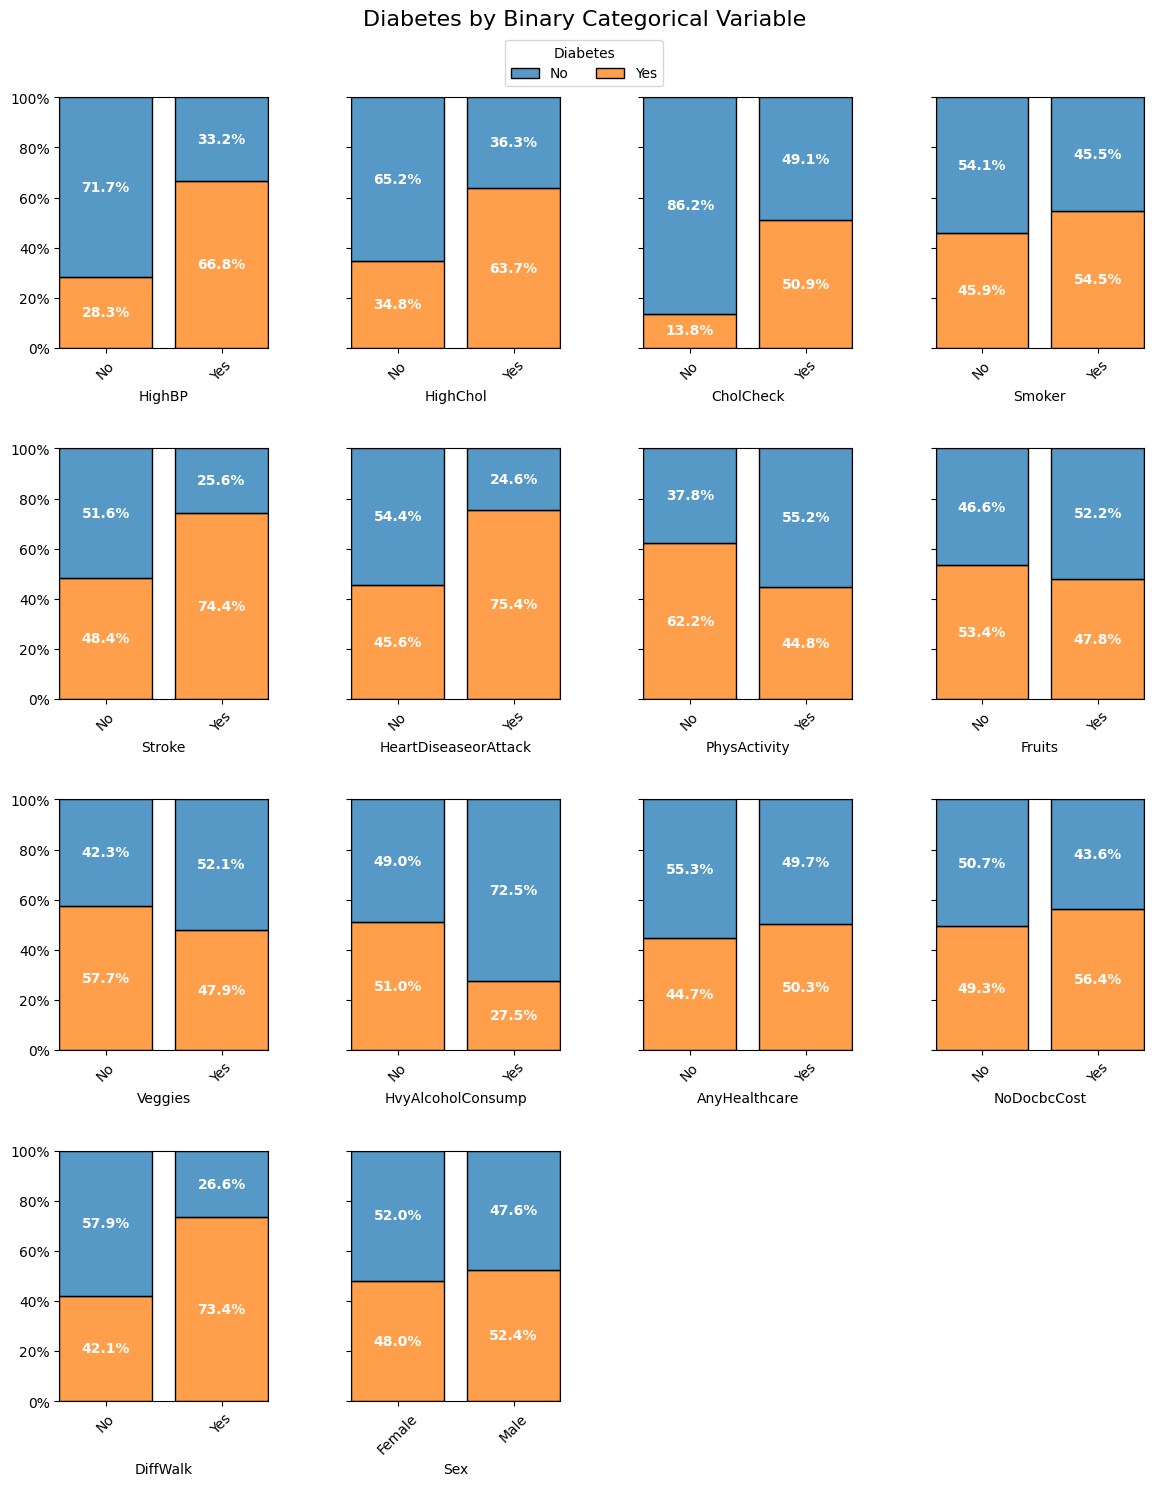

In [55]:
# Define grid size dynamically based on the number of binary columns
num_plots = len(binary_columns)
num_rows = (num_plots // 4) + (1 if num_plots % 4 != 0 else 0)  # Adjust rows dynamically
num_cols = 4  

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(14, 4 * num_rows), sharey=True)

# Flatten axs to a list for easy iteration
axs = axs.flatten()

# Loop through each binary categorical variable and plot it
for i, column in enumerate(binary_columns):
    h = sns.histplot(
        x=column,
        hue=target_column,
        data=df_diabetes_processed,
        multiple="fill",
        ax=axs[i],
        stat="percent",
        shrink=0.8,
    )

    h.tick_params(axis="x", labelrotation=45)
    h.yaxis.set_major_formatter(PercentFormatter(1))
    h.set_ylabel("")

    for bar in h.containers:
        h.bar_label(
            bar,
            label_type="center",
            labels=[f"{b.get_height():.1%}" for b in bar],
            color="white",
            weight="bold",
        )

    legend = h.get_legend()
    legend.remove()

# Hide any remaining empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])  # Remove empty axes

# Extract labels for the centralized legend
labels = [text.get_text() for text in legend.get_texts()]

# Create a single legend at the top center of the figure
fig.legend(
    handles=legend.legend_handles,
    labels=labels,
    loc="upper center",
    ncols=2,
    title="Diabetes",
    bbox_to_anchor=(0.5, 0.965),
)

fig.suptitle("Diabetes by Binary Categorical Variable", fontsize=16)
fig.align_labels()
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.925)
plt.show()


#### Insights from Binary Categorical Variables


1. High Blood Pressure & High Cholesterol:

- A higher proportion of diabetics have high blood pressure (66.8%) and high cholesterol (63.7%), compared to non-diabetics.
- This aligns with known risk factors for diabetes, as both conditions are linked to metabolic health.

2. Physical Activity:

- Lower levels of physical activity (62.8%) are observed among diabetics, compared to 37.2% of non-diabetics. 
- Regular exercise helps improve insulin sensitivity, allowing the body to use glucose more effectively, which in turn helps regulate blood sugar levels.

3. Cardiovascular Risks:

- Diabetics show higher rates of heart disease (75.4%) and stroke (74.4%), reinforcing the link between diabetes and cardiovascular conditions.

These findings highlight key disparities in health status, lifestyle factors, and healthcare access between diabetics and non-diabetics, reinforcing the importance of preventive care and lifestyle interventions. 

### Visualizing Non-Binary Categorical Variables

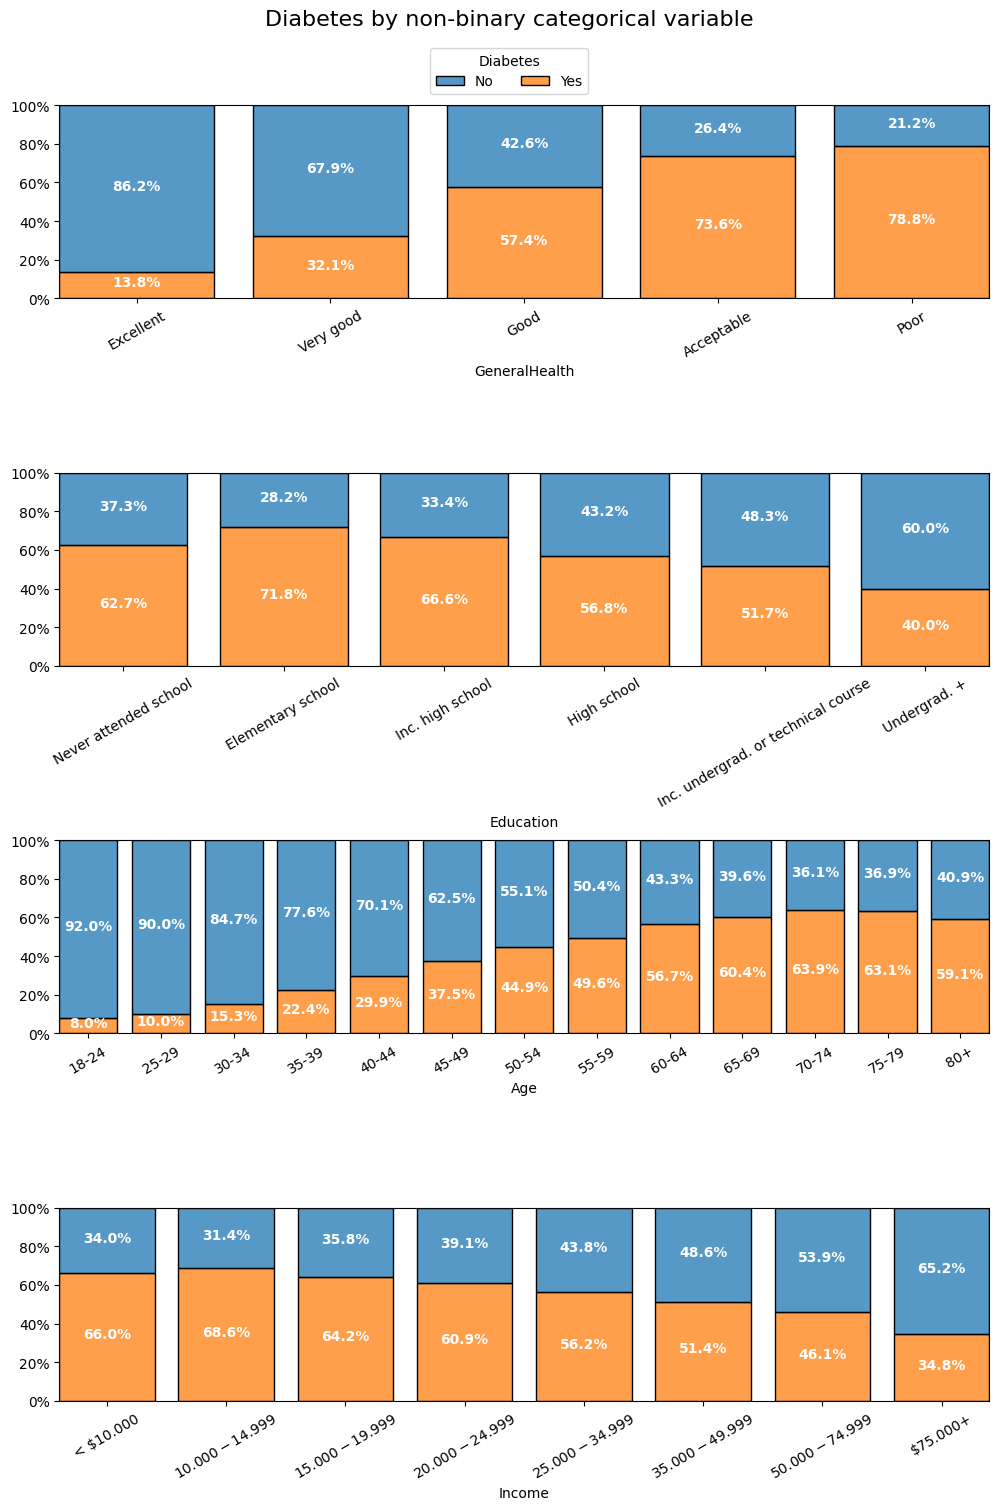

In [54]:
#Adjust the number of plots to the non-binary columns
num_plots = len(non_binary_columns)
num_cols = 1

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 4 * num_rows), sharey=True)

axs = axs.flatten()

for i, column in enumerate(non_binary_columns):
    h = sns.histplot(
        x=column,
        hue=target_column,
        data=df_diabetes_processed,
        multiple='fill',
        ax=axs.flat[i],
        stat='percent',
        shrink=0.8
        )
    
    h.tick_params(axis='x', labelrotation=30)
    h.yaxis.set_major_formatter(PercentFormatter(1))
    h.set_ylabel('')

    for bar in h.containers:
        h.bar_label(
            bar,
            label_type='center',
            labels=[f'{b.get_height():.1%}' for b in bar], 
            color='white', 
            weight='bold',
            fontsize=10,
            padding=2
            )

    legend = h.get_legend()
    legend.remove()

labels = [text.get_text() for text in legend.get_texts()]

fig.legend(
    handles=legend.legend_handles,
    labels=labels,
    loc='upper center',
    ncols=2,
    title='Diabetes',
    bbox_to_anchor=(0.5, 0.96)
    )

fig.suptitle('Diabetes by non-binary categorical variable', fontsize=16)
fig.align_labels()
plt.subplots_adjust(wspace=0.1, hspace=0.9, top=0.92)

plt.show()

### Insights from Non-Binary Categorical Variables

1. **General Health Condition:**
   - Diabetics are more prevalent among individuals reporting poorer health conditions. As self-reported health status declines, the proportion of diabetics increases significantly.
   - This trend highlights the strong association between diabetes and overall health deterioration, emphasizing the need for early intervention and management of chronic conditions.

2. **Education Levels:**
   - A diminished presence of diabetes is observed with higher levels of education. As educational attainment increases, the proportion of diabetics decreases.
   - This suggests that education plays a protective role, potentially through better health literacy, access to resources, and healthier lifestyle choices.

3. **Age Groups:**
   - Diabetes prevalence increases with age, reflecting the natural progression of metabolic changes and cumulative lifestyle factors over time.
   - While this trend is expected, it underscores the importance of targeted preventive measures and regular health screenings for older populations.

4. **Income Levels:**
   - Diabetes prevalence is higher in lower-income groups, with a clear tendency for the condition to diminish as income increases.
   - This disparity likely stems from socioeconomic factors, such as limited access to nutritious food, healthcare services, and preventive education, which disproportionately affect lower-income populations.

These findings reveal clear patterns in diabetes prevalence across non-binary categorical variables, emphasizing the interplay between socioeconomic, educational, and health-related factors. Addressing these disparities requires a multifaceted approach, including improved access to healthcare, education, and resources for vulnerable populations.

### Visualizing the Distribution of GeneralHealth and Income by Education Level

The following code generates a set of histograms to analyze the distribution of two non-binary categorical variables (GeneralHealth and Income) across different education levels. This visualization helps us understand how these variables interact with education and their potential relationship with diabetes status.

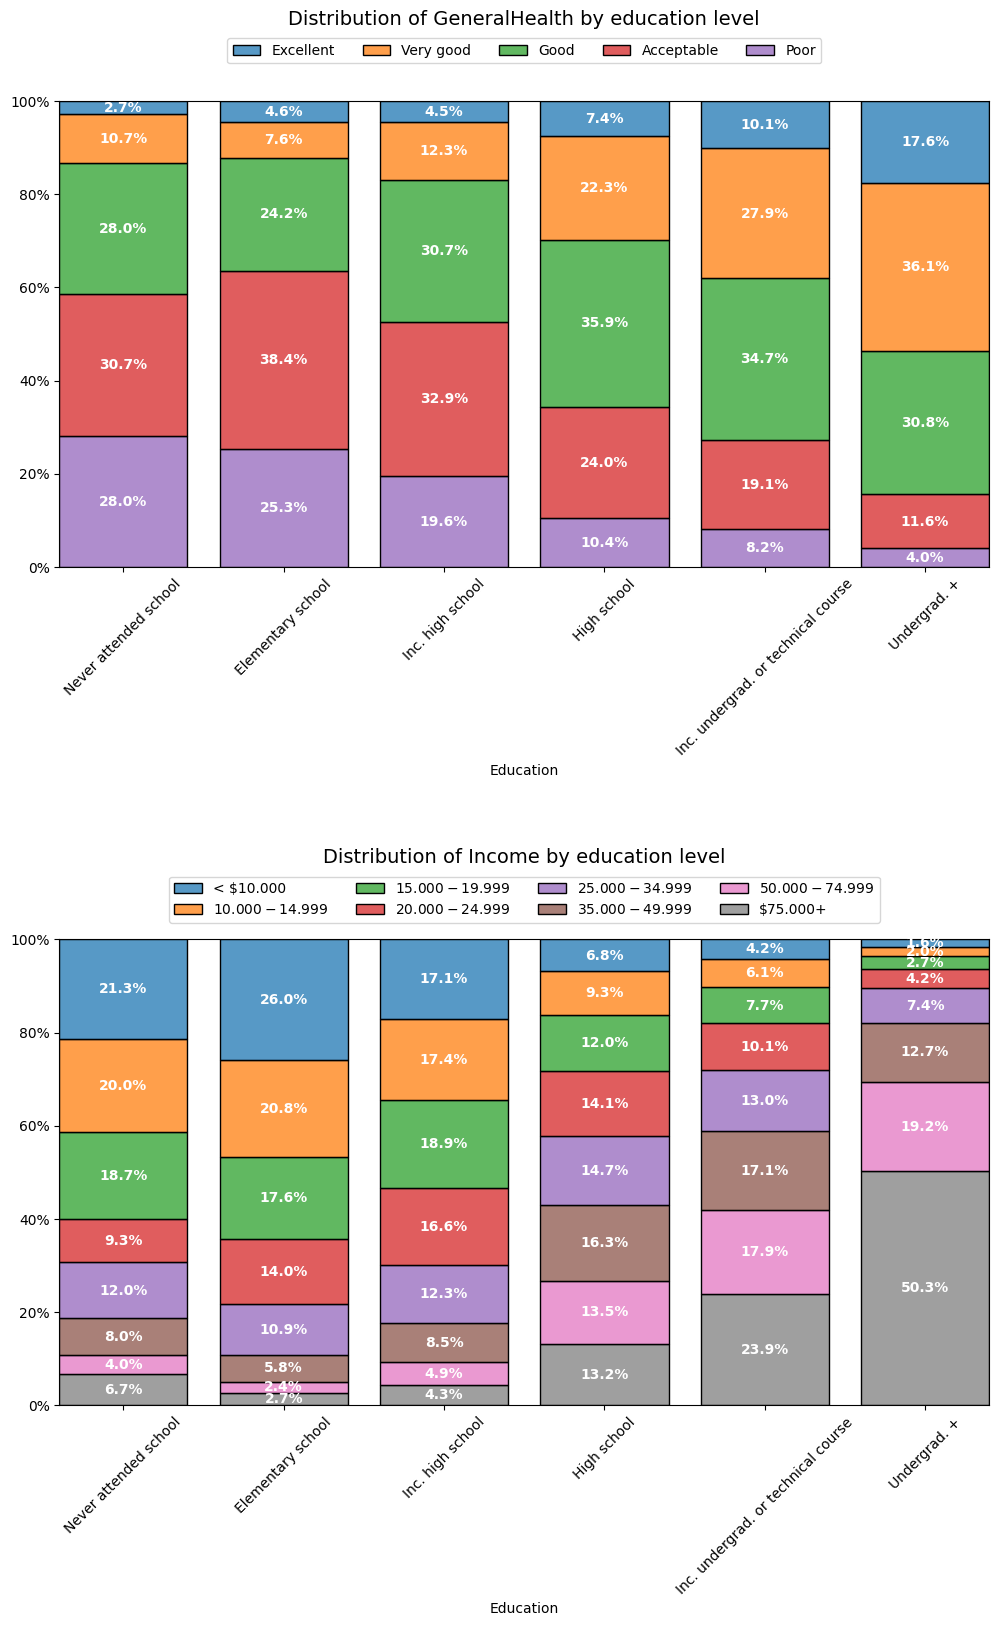

In [56]:
columns_analysis = ["GeneralHealth", "Income"]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))

for ax, column in zip(axs.flatten(), columns_analysis):
    h = sns.histplot(
        x="Education",
        hue=column,
        data=df_diabetes_processed,
        multiple='fill',
        ax=ax,
        stat='percent',
        shrink=0.8
        )
    h.tick_params(axis='x', labelrotation=45)

    h.yaxis.set_major_formatter(PercentFormatter(1))
    h.set_ylabel('')

    for bar in h.containers:
        h.bar_label(
            bar, 
            label_type='center', 
            labels=[f'{b.get_height():.1%}' for b in bar], 
            color='white',
            weight='bold'
            )

    legend = h.get_legend()

    labels = [text.get_text() for text in legend.get_texts()]

    number_itens = len(df_diabetes_processed[column].cat.categories)

    ax.legend(
        handles=legend.legend_handles,
        labels=labels,
        loc="upper center",
        ncols=number_itens if number_itens <= 6 else min(4, number_itens),
        bbox_to_anchor=(0.5, 1.15),
    )

    ax.set_title(f"Distribution of {column} by education level", fontsize=14, pad=55)

plt.subplots_adjust(wspace=0.1, hspace=0.8, top=0.925)

plt.show()

## Insights from the Visualization:
1. GeneralHealth by Education Level:

- The plot reveals how self-reported health status varies across different education levels. Poorer health conditions are more prevalent among individuals with lower education levels, which may correlate with higher diabetes prevalence.

2. Income by Education Level:

- The distribution of income across education levels highlights socioeconomic disparities. Lower income groups are more concentrated among individuals with less education, which aligns with the observed higher prevalence of diabetes in these groups.

## Contengency tables

Creating contingency tables for all categorical variables in the dataset, excluding the target variable (Diabetes). 

- These tables show the frequency distribution of categorical variables across diabetic and non-diabetic groups.

- Example: The HighBP table reveals the proportion of individuals with and without high blood pressure in each group.

In [60]:
tables_contingency = {}

for column in df_diabetes_processed.select_dtypes("category").columns:
    if column != target_column:
        tables_contingency[column] = pd.crosstab(df_diabetes_processed[target_column], df_diabetes_processed[column])

tables_contingency['HighBP']

HighBP,No,Yes
Diabetes,,
No,22118,13228
Yes,8742,26604


Presenting the normalized contingency tables:

In [21]:
for column in df_diabetes_processed.select_dtypes("category").columns:
    if column != target_column:
        display(
            pd.crosstab(
                df_diabetes_processed[target_column],
                df_diabetes_processed[column],
                margins=True,
                normalize="index"
            ).style.format("{:.2%}"))

HighBP,No,Yes
Diabetes,,
No,62.58%,37.42%
Yes,24.73%,75.27%
All,43.65%,56.35%


HighChol,No,Yes
Diabetes,,
No,61.87%,38.13%
Yes,32.99%,67.01%
All,47.43%,52.57%


CholCheck,No,Yes
Diabetes,,
No,4.27%,95.73%
Yes,0.68%,99.32%
All,2.47%,97.53%


Smoker,No,Yes
Diabetes,,
No,56.77%,43.23%
Yes,48.18%,51.82%
All,52.47%,47.53%


Stroke,No,Yes
Diabetes,,
No,96.81%,3.19%
Yes,90.75%,9.25%
All,93.78%,6.22%


HeartDiseaseorAttack,No,Yes
Diabetes,,
No,92.73%,7.27%
Yes,77.71%,22.29%
All,85.22%,14.78%


PhysActivity,No,Yes
Diabetes,,
No,22.45%,77.55%
Yes,36.95%,63.05%
All,29.70%,70.30%


Fruits,No,Yes
Diabetes,,
No,36.19%,63.81%
Yes,41.46%,58.54%
All,38.82%,61.18%


Veggies,No,Yes
Diabetes,,
No,17.89%,82.11%
Yes,24.36%,75.64%
All,21.12%,78.88%


HvyAlcoholConsump,No,Yes
Diabetes,,
No,93.81%,6.19%
Yes,97.65%,2.35%
All,95.73%,4.27%


AnyHealthcare,No,Yes
Diabetes,,
No,4.99%,95.01%
Yes,4.02%,95.98%
All,4.50%,95.50%


NoDocbcCost,No,Yes
Diabetes,,
No,91.80%,8.20%
Yes,89.41%,10.59%
All,90.61%,9.39%


GeneralHealth,Excellent,Very good,Good,Acceptable,Poor
Diabetes,,,,,
No,20.21%,38.17%,28.21%,9.94%,3.48%
Yes,3.23%,18.05%,38.07%,27.70%,12.95%
All,11.72%,28.11%,33.14%,18.82%,8.22%


DiffWalk,No,Yes
Diabetes,,
No,86.58%,13.42%
Yes,62.88%,37.12%
All,74.73%,25.27%


Sex,Female,Male
Diabetes,,
No,56.51%,43.49%
Yes,52.09%,47.91%
All,54.30%,45.70%


Age,18-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+
Diabetes,,,,,,,,,,,,,
No,2.55%,3.55%,4.91%,6.13%,6.99%,8.22%,10.71%,12.28%,12.39%,12.16%,8.21%,5.63%,6.27%
Yes,0.22%,0.40%,0.89%,1.77%,2.97%,4.93%,8.74%,12.06%,16.22%,18.55%,14.54%,9.63%,9.08%
All,1.38%,1.97%,2.90%,3.95%,4.98%,6.58%,9.72%,12.17%,14.30%,15.36%,11.38%,7.63%,7.68%


Education,Never attended school,Elementary school,Inc. high school,High school,Inc. undergrad. or technical course,Undergrad. +
Diabetes,,,,,,
No,0.08%,1.31%,3.26%,23.78%,27.38%,44.19%
Yes,0.13%,3.35%,6.50%,31.31%,29.29%,29.42%
All,0.11%,2.33%,4.88%,27.55%,28.33%,36.81%


Income,< $10.000,$10.000-$14.999,$15.000-$19.999,$20.000-$24.999,$25.000-$34.999,$35.000-$49.999,$50.000-$74.999,$75.000+
Diabetes,,,,,,,,
No,3.47%,3.99%,5.63%,7.37%,9.92%,14.13%,17.43%,38.06%
Yes,6.74%,8.73%,10.09%,11.47%,12.74%,14.97%,14.90%,20.36%
All,5.11%,6.36%,7.86%,9.42%,11.33%,14.55%,16.16%,29.21%


### Data Interpretation Challenges:

The unequal distribution of the dataset introduces potential biases that can complicate the analysis. For instance:

1. **Imbalanced Representation:**
   - Only **0.11%** of the total population (database population) never attended school, compared to **36.81%** who have completed undergraduate or higher education.
   - Similarly, just **5.11%** of the population earn less than $10,000 annually, while **29.21%** earn $75,000 or more.

2. **Statistical Power Issues:**
   - Small sample sizes in certain categories (e.g., individuals who never attended school or those earning < $10,000) reduce the statistical power to draw meaningful conclusions about these groups.
   - This imbalance can lead to overgeneralization or misinterpretation of results, as the analysis may disproportionately reflect trends in larger, more represented groups.

3. **Policy and Intervention Implications:**
   - The overrepresentation of higher-income and more educated individuals might skew policy recommendations, potentially neglecting the needs of underrepresented, high-risk groups.

While the data clearly shows that lower income and education levels are associated with higher diabetes prevalence, the unequal distribution of the dataset poses significant challenges. The small representation of certain groups (e.g., those with minimal education or low income) limits our ability to fully understand their unique risk factors and needs. Addressing these imbalances in future data collection and analysis is crucial to ensure equitable and effective interventions for all populations.

#### Chi-Square Test for Independence
Performs a chi-square test for independence on each contingency table to determine if there is a statistically significant association between the categorical variable and diabetes status.

For each variable, it prints:

- The chi-square statistic: Measures the strength of the association.

- The p-value: Indicates the statistical significance of the association.

In [ ]:
for column, table in tables_contingency.items():
    chi2, p_value, _, _ = chi2_contingency(table)
    print(f"{column} - {chi2=} - {p_value=}")

HighBP - chi2=10287.972984997781 - valor_p=0.0
HighChol - chi2=5911.8066998822505 - valor_p=0.0
CholCheck - chi2=939.6317718798653 - valor_p=2.3798712773419562e-206
Smoker - chi2=522.4810772937883 - valor_p=1.2211053080400827e-115
Stroke - chi2=1111.0793074560897 - valor_p=1.2908370989220163e-243
HeartDiseaseorAttack - chi2=3161.7202445322782 - valor_p=0.0
PhysActivity - chi2=1778.9607035956992 - valor_p=0.0
Fruits - chi2=206.50090830615105 - valor_p=7.967064756507964e-47
Veggies - chi2=444.0806516898606 - valor_p=1.4007103685991128e-98
HvyAlcoholConsump - chi2=635.0865339749427 - valor_p=3.9133962745676324e-140
AnyHealthcare - chi2=37.79561046998934 - valor_p=7.855833890083924e-10
NoDocbcCost - chi2=118.4167174482265 - valor_p=1.4053255735064045e-27
GeneralHealth - chi2=12304.318979903528 - valor_p=0.0
DiffWalk - chi2=5253.694843161374 - valor_p=0.0
Sex - chi2=139.26185542886512 - valor_p=3.860395909809483e-32
Age - chi2=6179.057132257292 - valor_p=0.0
Education - chi2=2132.2725515843

1. Significant Associations:

- Variables with low p-values (e.g., HighBP, HighChol, Income, etc.) are likely to have a meaningful relationship with diabetes status.

- These findings can guide further analysis and intervention strategies.

2. Non-Significant Associations:

- Variables with high p-values (e.g., > 0.05) may not have a strong association with diabetes status, suggesting they are less relevant for predictive modeling or intervention planning.

## Correlation Analysis

In [23]:
results_correlation = df_diabetes_processed.select_dtypes("category").apply(lambda column: column.cat.codes).corr(method="spearman", numeric_only=False)

results_correlation

,Diabetes,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GeneralHealth,DiffWalk,Sex,Age,Education,Income
Diabetes,1.000000,0.381516,0.289213,0.115382,0.085999,0.125427,0.211523,-0.158666,-0.054077,-0.079293,-0.094853,0.023191,0.040977,0.414259,0.272646,0.044413,0.261620,-0.169926,-0.232529
HighBP,0.381516,1.000000,0.316515,0.103283,0.087438,0.129060,0.210750,-0.136102,-0.040852,-0.066624,-0.027030,0.035764,0.026517,0.324038,0.234784,0.040819,0.322180,-0.143543,-0.196896
HighChol,0.289213,0.316515,1.000000,0.085981,0.093398,0.099786,0.181187,-0.090453,-0.047384,-0.042836,-0.025443,0.031532,0.033199,0.239138,0.162043,0.017324,0.217974,-0.083177,-0.110289
CholCheck,0.115382,0.103283,0.085981,1.000000,-0.004331,0.022529,0.043497,-0.008249,0.017384,0.000349,-0.027146,0.106800,-0.062669,0.060257,0.044430,-0.007991,0.099208,-0.007693,0.007271
Smoker,0.085999,0.087438,0.093398,-0.004331,1.000000,0.064658,0.124418,-0.079823,-0.074811,-0.029926,0.077835,-0.012939,0.035799,0.149960,0.119789,0.112125,0.098822,-0.152918,-0.112241
Stroke,0.125427,0.129060,0.099786,0.022529,0.064658,1.000000,0.223394,-0.079985,-0.008996,-0.047601,-0.023395,0.006484,0.036198,0.182517,0.192266,0.003822,0.123544,-0.071889,-0.134487
HeartDiseaseorAttack,0.211523,0.210750,0.181187,0.043497,0.124418,0.223394,1.000000,-0.098223,-0.019436,-0.036315,-0.037130,0.015687,0.036029,0.268815,0.232611,0.098161,0.225231,-0.093727,-0.148924
PhysActivity,-0.158666,-0.136102,-0.090453,-0.008249,-0.079823,-0.079985,-0.098223,1.000000,0.133813,0.149322,0.019111,0.027089,-0.063302,-0.270967,-0.276868,0.051753,-0.092685,0.193831,0.202370
Fruits,-0.054077,-0.040852,-0.047384,0.017384,-0.074811,-0.008996,-0.019436,0.133813,1.000000,0.238605,-0.033246,0.029385,-0.045843,-0.099559,-0.050784,-0.088723,0.067778,0.104653,0.076732
Veggies,-0.079293,-0.066624,-0.042836,0.000349,-0.029926,-0.047601,-0.036315,0.149322,0.238605,1.000000,0.022090,0.029152,-0.037146,-0.117258,-0.084072,-0.052604,-0.017208,0.153539,0.155816


The initial correlation matrix generated using the Spearman method is difficult to interpret due to its size and complexity. To make the analysis more intuitive, we transform the data and visualize the correlations in a more user-friendly way.

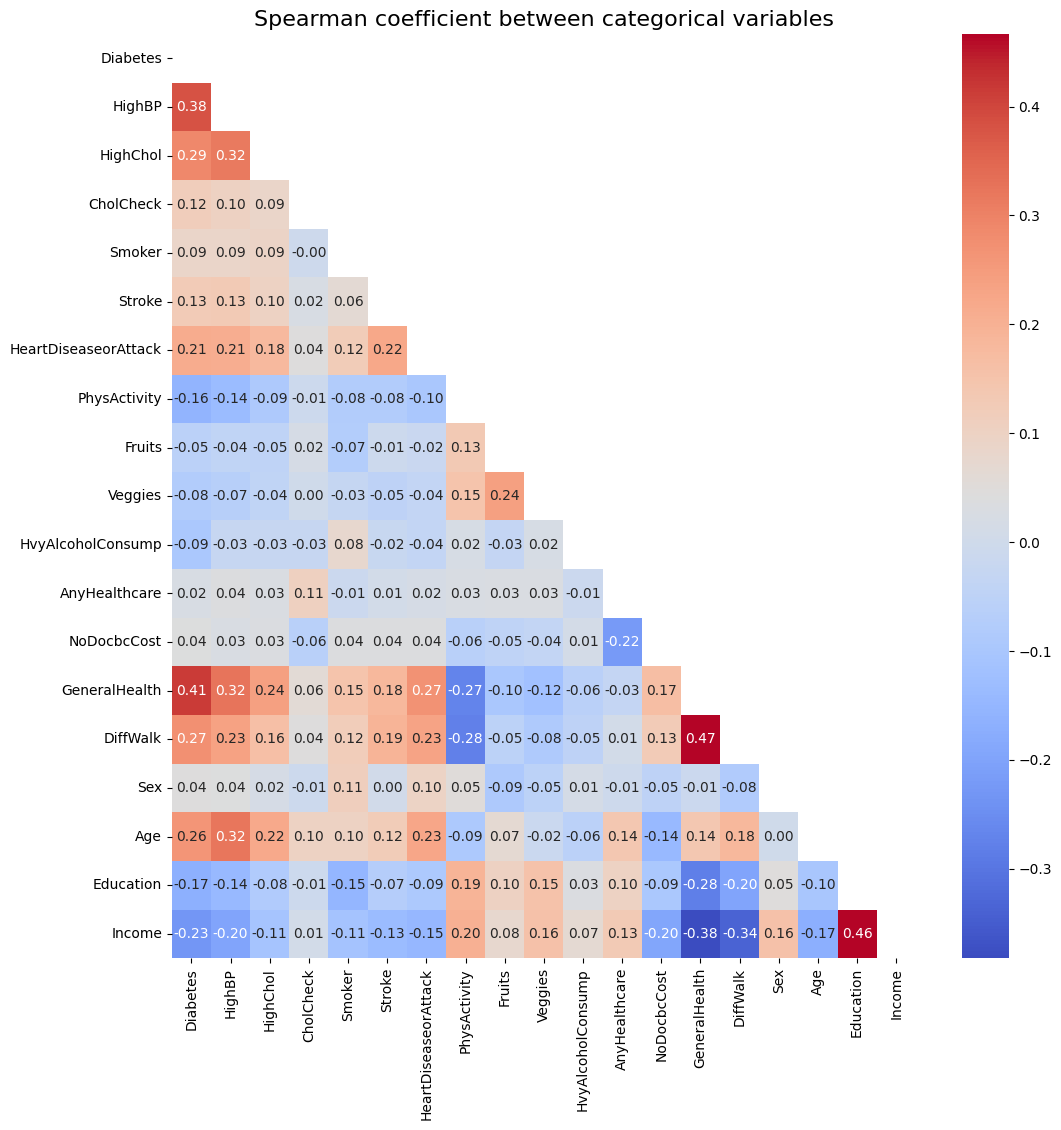

In [ ]:
# Create a mask for the upper triangle of the matrix
matrix = np.triu(results_correlation)

fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(results_correlation, mask=matrix, annot=True, fmt=".2f", ax=ax, cmap="coolwarm")

plt.title("Spearman Coefficient between Categorical Variables", fontsize=16)

plt.show()

### Strongest Positive Correlations:

1. Diabetes and GeneralHealth (0.41):

2. Diabetes and HighBP/HighCol (0.38)/(0.29):

3. Diabetes and DiffWalk/Age (0.27)/(0.26)

4. Diabetes and HeartDiseaseorAttack (0.21)

- Extra: Education and Income (0.46)

### Strongest Negative Correlations:

1. Diabetes and Income (-0.23):

2. Diabetes and Education (-0.17)

3. Diabetes and PhysActivity (-0.16):

- Extra: GeneralHealth and Income (-0.38):

### Final Conclusion

This analysis highlights the complex interplay between diabetes, lifestyle factors, socioeconomic status, and overall health. The strong links between diabetes and cardiovascular issues reinforce the importance of early intervention, lifestyle modifications, and improved access to healthcare. Additionally, the negative correlations with income and education suggest that social determinants of health play a critical role in diabetes risk and management.

Future studies could explore causal relationships and assess the impact of preventive measures on diabetes prevalence in different populations.